# 예지 보수 Predictive Maintenance (PM)

- 보수의 종류
  > 고장 후 보수: 기기가 고장나면 보수를 하는 것   
  > 정기적인 보수: 일정한 시간 간격으로 보수를 하는 것    
  > 예지 보수: 고장을 예측하여 적절한 시점에 보수를 하는 것    
- 예제
  - 항공기 엔진 고장 시점 및 일정 기간내 고장발생 여부 예측
  - 회귀모델과 분류모델로 접근 가능
  - RF와 LSTM 비교
  - 시계열 특성 추가 방법

## PM 회귀 모델
- TTF(time to fail): 고장까지 남은 시간을 예측하는 회귀 모델로 구현
<img src="https://github.com/data-labs/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-02-15%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%2010.02.12.png?raw=1" align='left'>

- X : (특정시점의) 상태값, Y 는 잔여수명

## PM 분류 모델 (이진 분류)
- U (Unsafe): TTF가 주어진 경계치 이하로 낮은 위험한 상태
- U : 잔여수명이 3년 이하로 남았는지 안 남았는지에 따라서 0/1을 가짐.
  분류모델을 이진이 아니라 3진분류로 나눌 수도 있음.. 여러가지로 나누는 것도 가능. 등급별로..
- U 값이 0/1을 갖는 이진 분류 모델로 구현
<img src="https://github.com/data-labs/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-02-15%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%2010.03.35.png?raw=1" align='left'>

# Import

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import keras
from keras import Sequential
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMClassifier, LGBMRegressor
from keras.layers import Dropout, LSTM, Dense, Activation
from sklearn.metrics import r2_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report

# 데이터
- 훈련 데이터에는 엔진별 가동 데이터와 수명정보가 있고 (고장시점까지 데이터가 주어진다)
- 테스트 데이터에는 엔진 가동 정보만 있고 정답은 (향후 잔여수명)은 별도의 truth 데이터로 제공한다

In [176]:
# 훈련 데이터
train_df = pd.read_csv('http://azuremlsamples.azureml.net/templatedata/PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [99]:
train_df   #ID는 엔진, Cycle은 해당 엔진의 나이수 1->>MAX(최대값) = 수명

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [177]:
# 테스트 데이터
test_df = pd.read_csv('http://azuremlsamples.azureml.net/templatedata/PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [178]:
# 정답 (테스트데이터의 잔여 수명) 데이터
truth_df = pd.read_csv('http://azuremlsamples.azureml.net/templatedata/PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

## 레이블(y)  추가
- 회귀 분석에서는 잔여시간(TTF) (=RUL : Remanining Useful Life) 을 예측하며 각 상태(State) 값을 보고 앞으로 남은 잔여시간을 예측하는 회귀 모델을 만든다
- 분류 분석에서는 앞으로 특정 기간 이내에 고장 날지 여부를 예측한다. 예를 들어 30 사이클 이내에 고장 여부를 분류한다 (0/1 구분)
- 회귀 및 분류를 위한 레이블을 각각 만들겠다

- RUL(Remaining Useful Life)
  - 같은 엔진 ID에 대해서 최대 cycle 값이 "수명"을 나타낸다
  - 이 수명값을 rul 데이터프레임에 저장한다
  - 같은 엔진들 즉 같은 'id'를 같는 샘플들을 별도의 데이터프레임으로 만드는 groupby를 사용한다

In [179]:
# 모든 행에 대해서 잔여수명 레이블 추가
# rul 데이터프레임에서 최대 수명을 max라고 지정

rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()

#train_df 데이터프레임을 id 기준으로 쪼갬. 그 중 cycle 컬럼에 대한 MAX 값을 뽑는다.
# SELECT MAX(cycle) FROM train_df GROUP BY id

rul.columns = ['id', 'max'] #100개 엔진의 최대 수명
rul

,id,max
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269
...,...,...
95,96,336
96,97,202
97,98,156
98,99,185


## 엔진 고장시점 추가

- 고장 시점(max)에서 현재 cycle을 빼면 잔여수명(RUL)이 된다

In [180]:
train_df = train_df.merge(rul, on=['id'], how='left')  # ID를 기준으로 값을 합쳐줌. (train_df + rul)

train_df['RUL'] = train_df['max'] - train_df['cycle']  # 최대수명에서 현재 cycle을 빼주면 잔여수명 Column값이 됨.
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,max,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192,187


In [181]:
# 고장 시점은 필요없으므로 삭제한다
train_df.drop('max', axis=1, inplace=True)

## 분류용 레이블
- 이진분류를 위해서, 앞으로 30 사이클 이내에 고장이 날 지를 예측하는 이진 분류용 레이블을 만든다

In [182]:
# 이진분류, 삼진 분류를 위한 레이블
w = 30
train_df['label'] = np.where(train_df['RUL'] <= w, 1, 0 )  #잔여수명이 30보다 작으면 1, 아니면 0 ... 이 함수가 WHERE (Ture, False 에 따른 값 설정가능 )
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


## 스케일링
- 모든 센서 값의 최소, 최대 값이 0~1 범위를 갖도록 스케일링한다
- 스케일링 대상이 아닌 ['id','cycle','ttf','label_bnc','label_mcc'] 컬럼은 제외하기 위해서 difference 함수를 사용한다
- cycle 값을 하나 복사하여 스케일링한다 - 이를 사용할지 여부는 나중에 판단한다
 - 수명에 대한 힌트를 미리 주는 셈이다! 따라서 cycle은 제외한다.


In [183]:
# MinMax normalization

cols_normalize = train_df.columns.difference(['id','cycle','RUL','label'])
min_max_scaler = MinMaxScaler() #보통은 표준 Scaling이 좋은데, 기계에서 나온 값은 MinMax Scaling을 해주는게 더 나음.
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0


In [22]:
train_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,0.477011,0.250000,0.0,0.0,0.686747,0.587312,0.782917,0.0,...,0.558824,0.194344,0.656791,0.0,0.750000,0.0,0.0,0.271318,0.109500,4
20627,100,197,0.408046,0.083333,0.0,0.0,0.701807,0.729453,0.866475,0.0,...,0.500000,0.188668,0.727203,0.0,0.583333,0.0,0.0,0.124031,0.366197,3
20628,100,198,0.522989,0.500000,0.0,0.0,0.665663,0.684979,0.775321,0.0,...,0.529412,0.212148,0.922278,0.0,0.833333,0.0,0.0,0.232558,0.053991,2
20629,100,199,0.436782,0.750000,0.0,0.0,0.608434,0.746021,0.747468,0.0,...,0.514706,0.203065,0.823394,0.0,0.583333,0.0,0.0,0.116279,0.234466,1


## 테스트 데이터 전처리
- 훈련 데이터와 반드시 동일한 전처리를 해야 한다
- (주의) 훈련 데이터에서 사용한 스케일러를 사용한다
 - min_max_scaler.transform()를 사용해야 함

In [184]:
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377


- 정답 데이터를 테스트 데이터에 추가하기 위해서 truth 정보를 이용한다

In [185]:
# 테스트 데이터에 정답 잔여 수명 컬럼을 추가한다
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)



In [48]:
truth_df

,id,max
0,1,143
1,2,147
2,3,195
3,4,188
4,5,189
...,...,...
95,96,234
96,97,216
97,98,180
98,99,214


In [186]:
# 각 행별로 잔여수명을 계산한다
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,138


In [187]:
# 분류를 위한 레이블 추가
test_df['label'] = np.where(test_df['RUL'] <= w, 1, 0 )
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,142,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,141,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,140,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,139,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,138,0


# 탐색적 분석

In [188]:
# 훈련 및 테스트 데이터프레임 크기
train_df.shape, test_df.shape

((20631, 28), (13096, 28))

In [46]:
train_df.columns

Index(['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
       's15', 's16', 's17', 's18', 's19', 's20', 's21', 'RUL', 'label'],
      dtype='object')

In [189]:
features = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

# 목적변수인 RUL과 상관관계가 큰 순으로 소팅해 본다
train_df[features].corrwith(train_df.RUL).sort_values(ascending=False)

s12         0.671983
s7          0.657223
s21         0.635662
s20         0.629428
setting2   -0.001948
setting1   -0.003198
s6         -0.128348
s14        -0.306769
s9         -0.390102
s13        -0.562569
s8         -0.563968
s3         -0.584520
s17        -0.606154
s2         -0.606484
s15        -0.642667
s4         -0.678948
s11        -0.696228
setting3         NaN
s1               NaN
s5               NaN
s10              NaN
s16              NaN
s18              NaN
s19              NaN
dtype: float64

### 시각화

- 여러 특성의 시계열 변화를 파악하는 함수를 정의한다
- 센서 s에 대해서 랜덤하게 선택한 N개의 엔진 데이터 보기

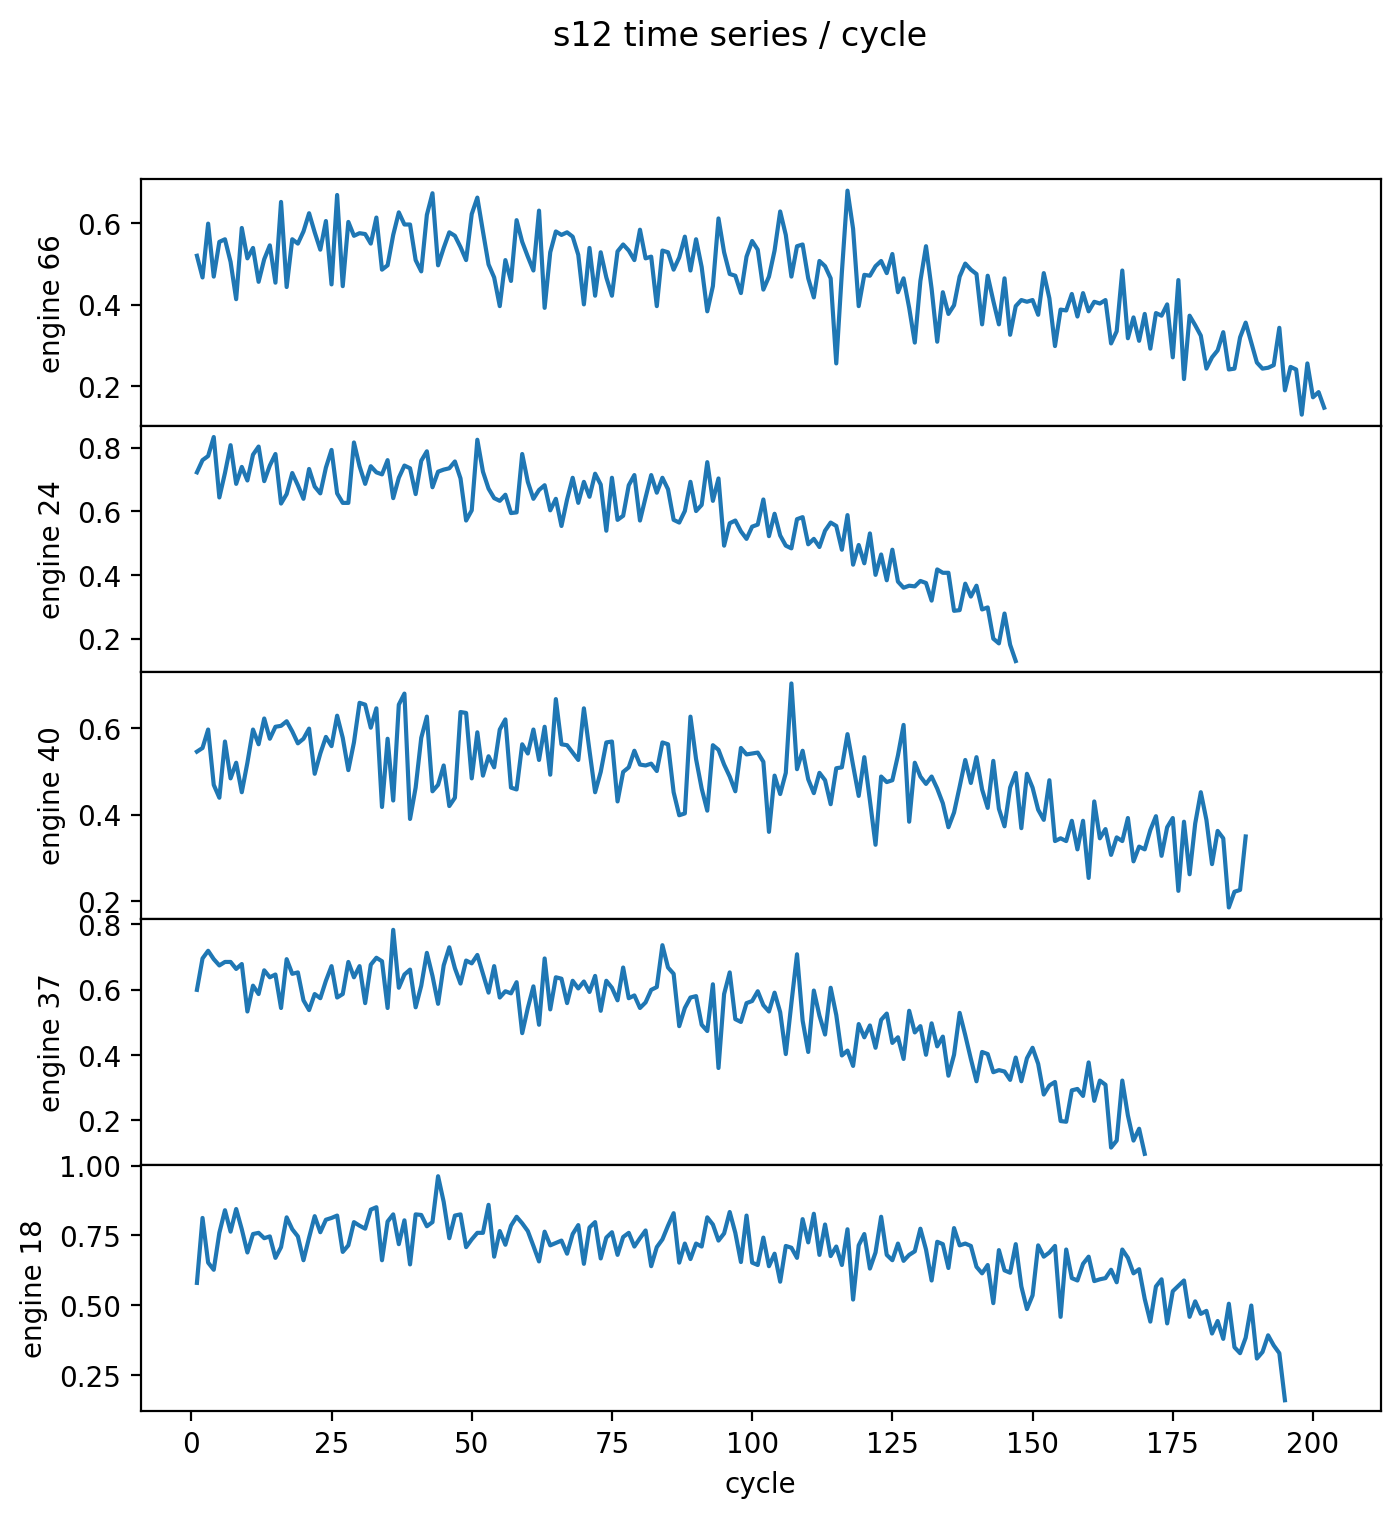

In [190]:
def plot_time_series(df, s, N):
    fig, axes = plt.subplots(N, 1, sharex=True, figsize = (8, 8))
    fig.suptitle(s + ' time series / cycle', fontsize=12)

    select_engines = np.random.choice(range(1,101), N, replace=False).tolist()

    for e_id in select_engines:
        df2 = df[['cycle', s]][df.id == e_id]
        i = select_engines.index(e_id)
        axes[i].plot(df2['cycle'],df2[s])
        axes[i].set_ylabel('engine ' + str(e_id))
        axes[i].set_xlabel('cycle')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

plot_time_series(train_df, 's12',5)

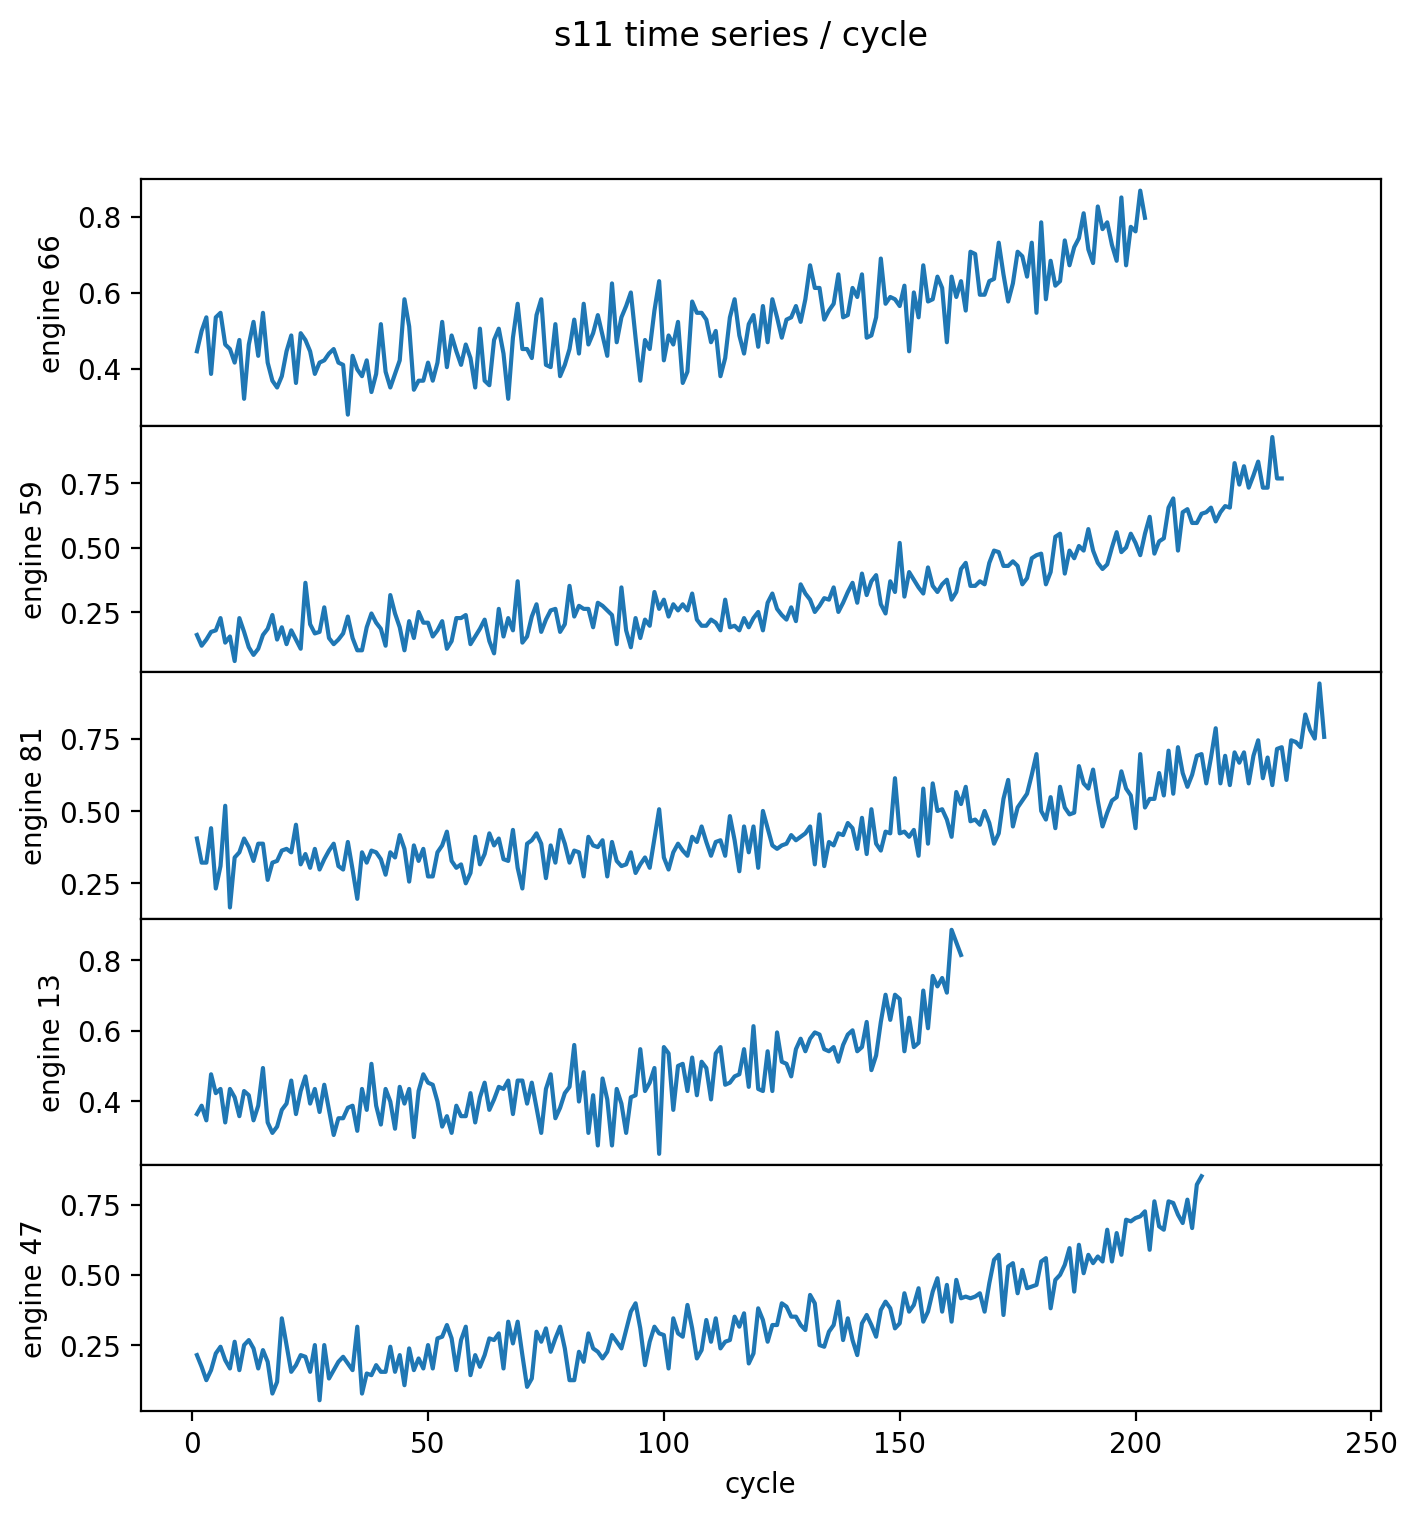

In [52]:
plot_time_series(train_df, 's11',5)

# 랜덤 포레스트 사용

## 회귀모델
- 학습 및 테스트 데이터

In [191]:
X_train = train_df[features]
X_test = test_df[features]
y_train = train_df['RUL']
y_test = test_df['RUL']

In [158]:
def show_regression_result(y_test, y_pred, N=100):
    plt.rc('figure', figsize=(6,4))
    error = y_pred - y_test
    print("MAE=", np.abs(error).mean())
    print("rmse=", np.sqrt((error**2).mean()))
    print("max error=", max(abs(error)))
    print("R2=",r2_score(y_test, y_pred))
    if N > 0:
      plt.plot(y_test[:N], 'r.-', label='y_test')
      plt.plot(y_pred[:N], 'b.-', label='y_pred')
      plt.legend()
      plt.show()

def plot_features_weights(features, weights):
    W = pd.DataFrame({'Weights':weights}, features)
    fig_size= 6
    if len(features) > 30: fig_size=12
    if len(features) > 40: fig_size=18
    W.sort_values(by='Weights', ascending=True).plot(kind='barh', color='r', figsize=(8,fig_size))
    plt.xlabel('Features Importance/Weights')
    plt.gca().legend_ = None

MAE= 37.17390660887936
rmse= 48.39948399086455
max error= 219.46867479433934
R2= 0.32655301945956594


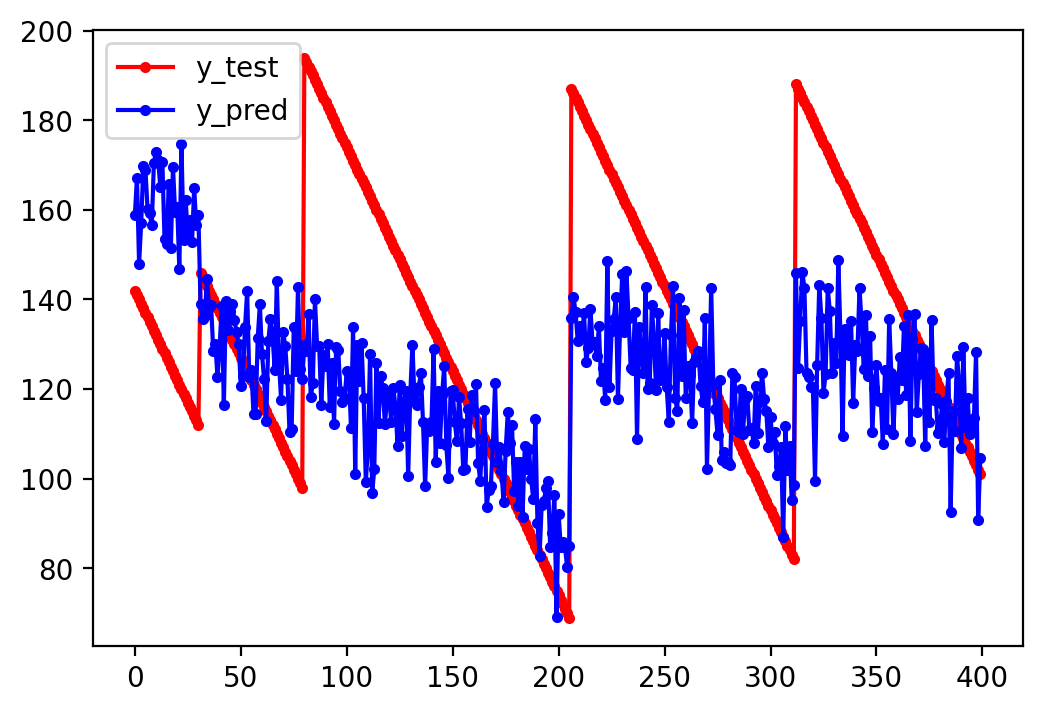

In [192]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()  #24개의 Sensor 값을 인자로 해서 가중값으로 수명을 맞춰봐.
lin.fit(X_train, y_train)
y_pred = lin.predict(X_test)
show_regression_result(y_test, y_pred, 400)
#잔여수명이 얼마 안 남았을때는 잘 맞추는데, 잔여수명이 일정수치 이상인 경우는 거의 맞추질 못 함.
#선형모델에서는 증상?특징?이 130정도 되야 나타난다는 말. => 성능이 나쁜게 아니라 아직 증상이 나타나지 않아서 못 찾는 것

MAE= 35.23692730604765
rmse= 46.64530788720861
max error= 219.8
R2= 0.37448478890833226


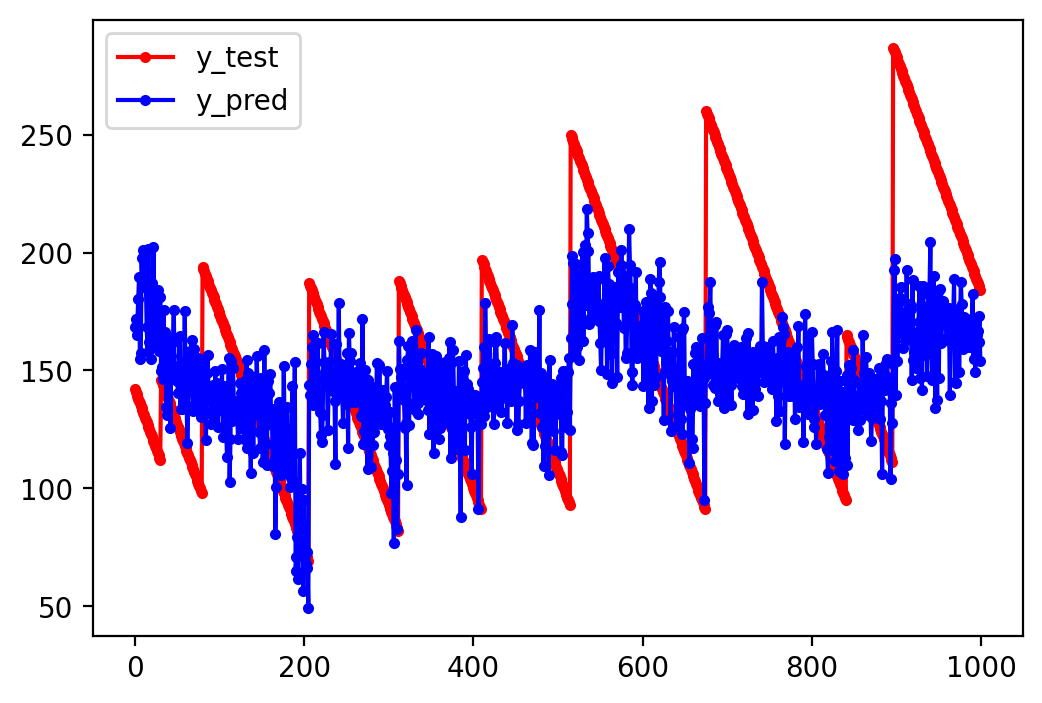

In [57]:
rfr = RandomForestRegressor(50)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
show_regression_result(y_test, y_pred, 1000)
#RandonForest 도 선형모델보다는 낫지만 거의 변화는 없음. 속도만 빨라짐.
#따라서 이런 경우는 커버하려면 잔여수명이 150이상 건들은 빼고 채점(TEST)하면 됨.

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2832
[LightGBM] [Info] Number of data points in the train set: 20631, number of used features: 17
[LightGBM] [Info] Start training from score 107.807862
MAE= 34.584234805057974
rmse= 46.08984844439965
max error= 214.27754840397589
R2= 0.3892935494203966


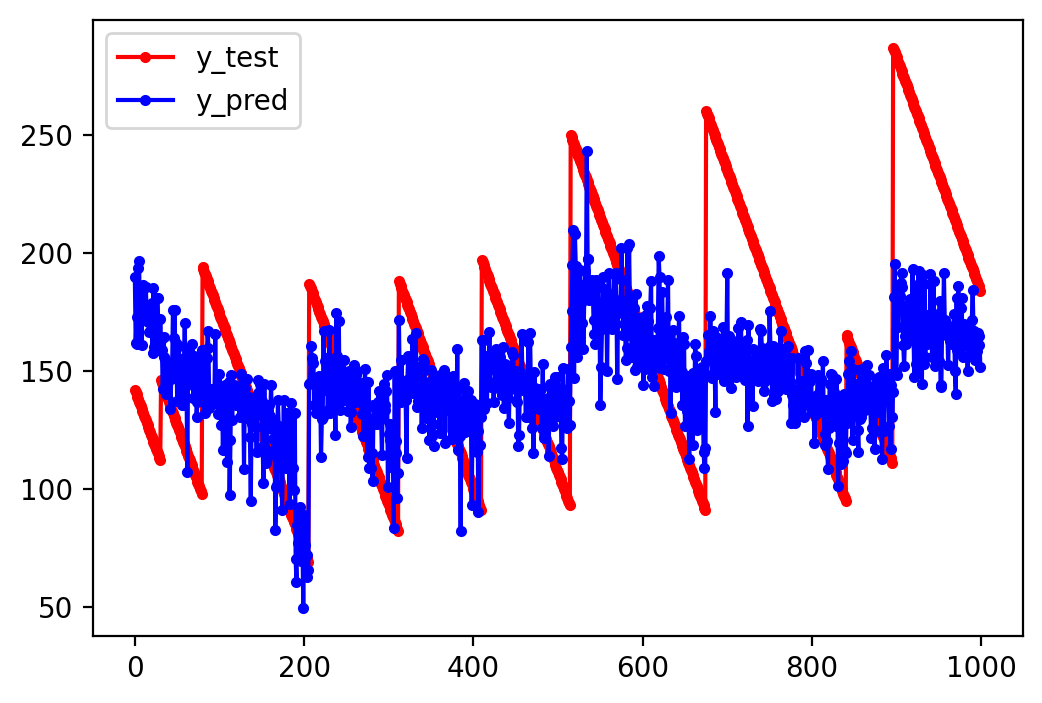

In [58]:
lgbm_r = LGBMRegressor()
lgbm_r.fit(X_train, y_train)
y_pred = lgbm_r.predict(X_test)
show_regression_result(y_test, y_pred,1000)

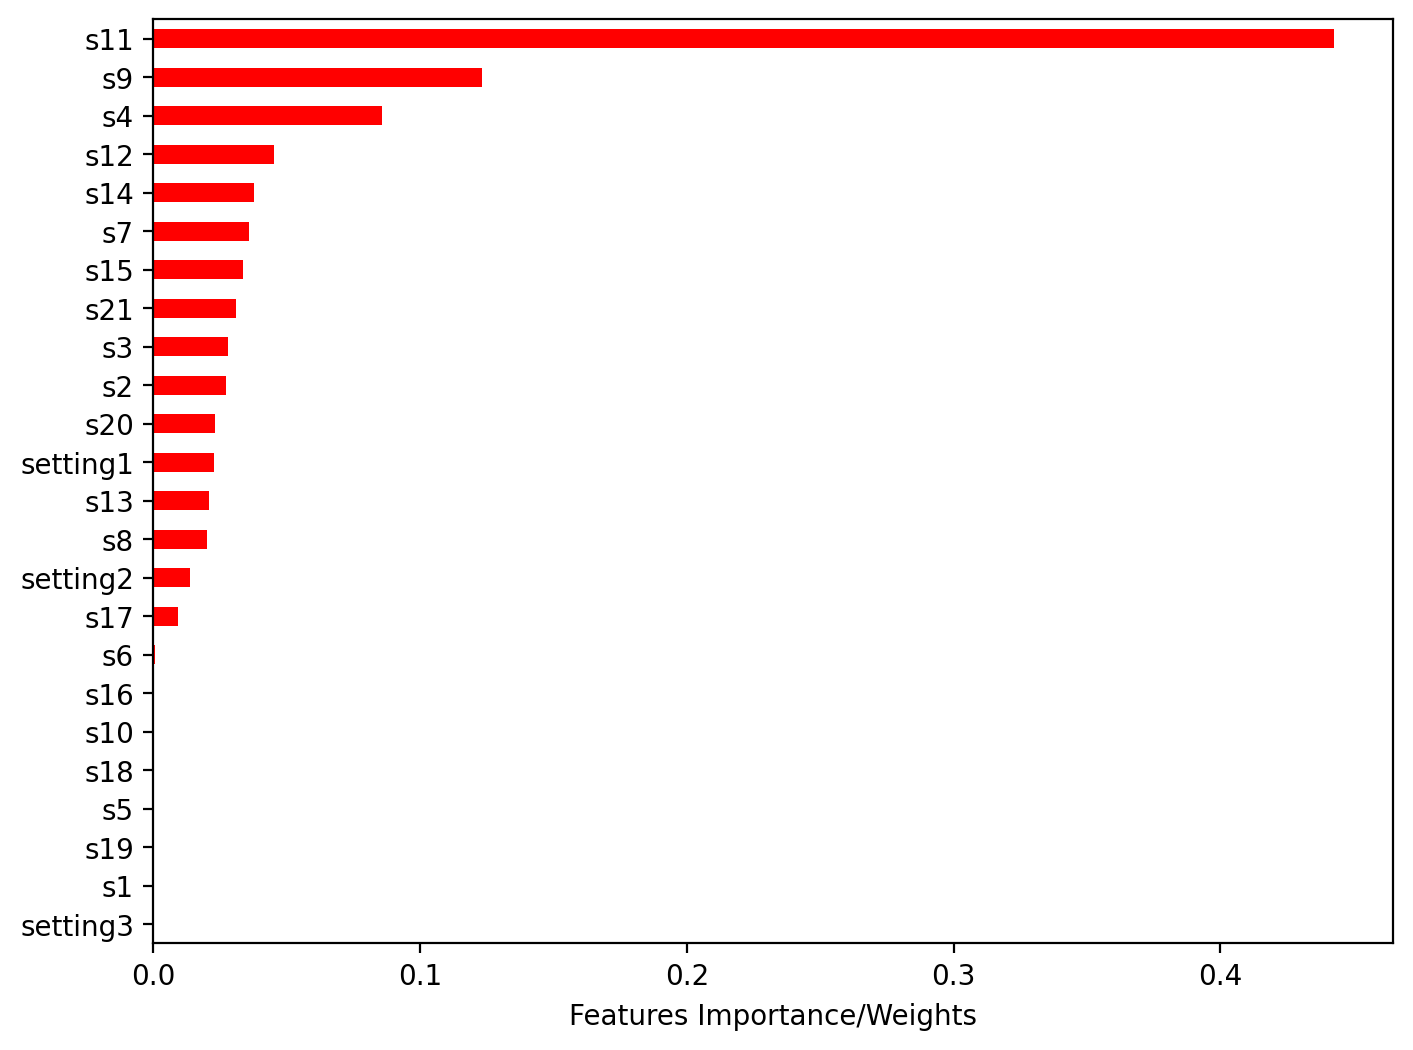

In [59]:
plot_features_weights(X_train.columns, rfr.feature_importances_)

# 일부 특성만 사용하는 경우

In [193]:
features_s = ['s2','s4','s7','s9','s11','s12','s14','s15','s17','s20','s21']
X_train_s = train_df[features_s]
X_test_s = test_df[features_s]
y_train = train_df['RUL']
y_test = test_df['RUL']

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2832
[LightGBM] [Info] Number of data points in the train set: 20631, number of used features: 17
[LightGBM] [Info] Start training from score 107.807862
MAE= 34.584234805057974
rmse= 46.08984844439965
max error= 214.27754840397589
R2= 0.3892935494203966


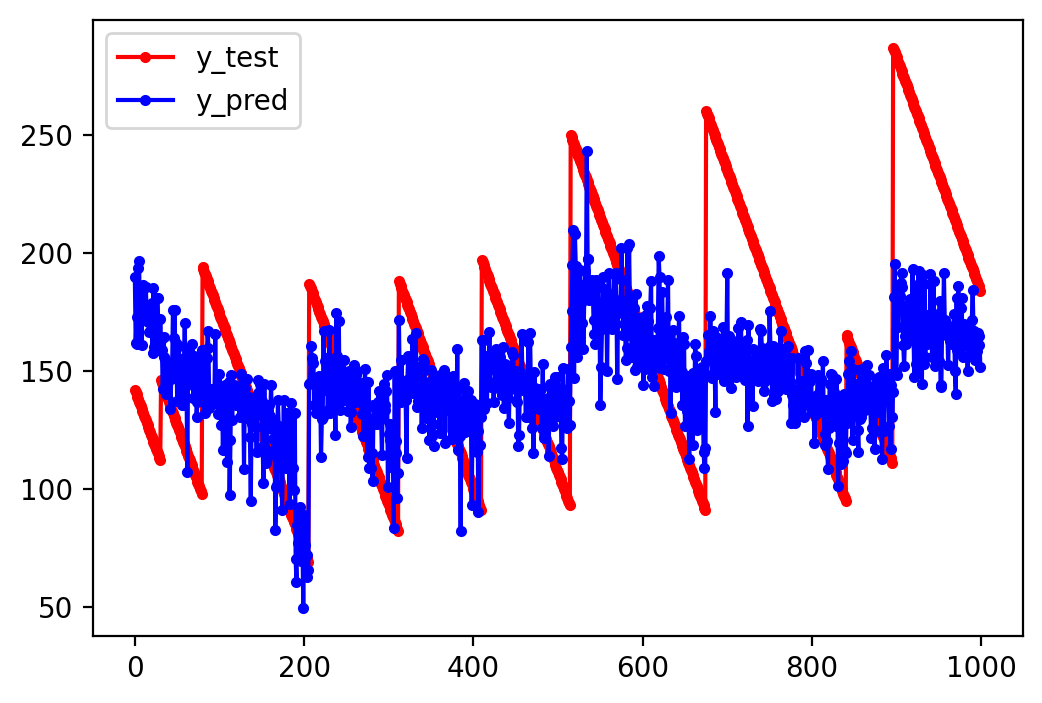

In [ ]:
lgbm_r = LGBMRegressor()
lgbm_r.fit(X_train, y_train)
y_pred = lgbm_r.predict(X_test)
show_regression_result(y_test, y_pred,1000)

## 분류 모델

In [194]:
y_train_c = train_df['label']
y_test_c = test_df['label']

In [136]:
def show_clf_result(y_test, y_pred):
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [164]:
model = RandomForestClassifier
model

sklearn.ensemble._forest.RandomForestClassifier

In [195]:
rfc = RandomForestClassifier() #분류기를 만든다.(모델 호출하여)
rfc.fit(X_train, y_train_c)
y_pred = rfc.predict(X_test)

proba = rfc.predict_proba(X_test)[:,1] # 30 cycle에 대한 recall을 높이고 싶으면, TreshHold를 0.5->0.1 로... 더 밑으로 낮추면 됨.

In [196]:

y_pred= proba>0.1

show_clf_result(y_test_c, y_pred)

#분류모델에서는 Accuracy 뿐만아니라 0과 1에 대한 Precision과 Recall을 봐야함.
# 0 = 정상 = 30사이클 안에 고장이 안 날 것
# 1 = 비정상 = 30사이클 안에 고장이 날 것
# recall 실제 값 중에서 찾아낸 % : recall 0.6 => 전체 대상 중 60%만 찾아냄.
# 1 일때 확률, recall이 안 좋음.
# 30 cycle에 대한 recall을 높이고 싶으면, TreshHold를 0.5->0.1 로... 더 밑으로 낮추면 됨.

[[12362   402]
 [   32   300]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     12764
           1       0.43      0.90      0.58       332

    accuracy                           0.97     13096
   macro avg       0.71      0.94      0.78     13096
weighted avg       0.98      0.97      0.97     13096



## 특성 추가
- 이동평균, 이동분산 등의 컬럼을 추가해본다


In [64]:
def rolling_average(df, window):
    df_av = df.rolling(window, min_periods=1).mean()
    df_av.columns = [col + "_av" + str(window) for col in df.columns]
    return df_av
def rolling_std(df, window):
    df_std = df.rolling(window, min_periods=1).std().fillna(0)
    df_std.columns = [col + "_std" + str(window) for col in df.columns]
    return df_std

## 훈련데이터 특성 추가
- 이동평균과 이동분산 추가 윈도우;15

In [65]:
X_train.shape

(20631, 24)

In [66]:
window = 15
add1 = rolling_average(X_train, window)
add2 = rolling_std(X_train, window)
X_train_ext = pd.concat((X_train, add1, add2), axis=1)
X_train_ext.shape

(20631, 72)

- 테스트 데이터 특성 추가

In [67]:
add1 = rolling_average(X_test, window)
add2 = rolling_std(X_test, window)
X_test_ext = pd.concat((X_test, add1, add2), axis=1)
X_test_ext.shape

(13096, 72)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10847
[LightGBM] [Info] Number of data points in the train set: 20631, number of used features: 51
[LightGBM] [Info] Start training from score 107.807862
MAE= 38.084225828088954
rmse= 50.456814970893575
max error= 220.45080762659813
R2= 0.2680833740427425


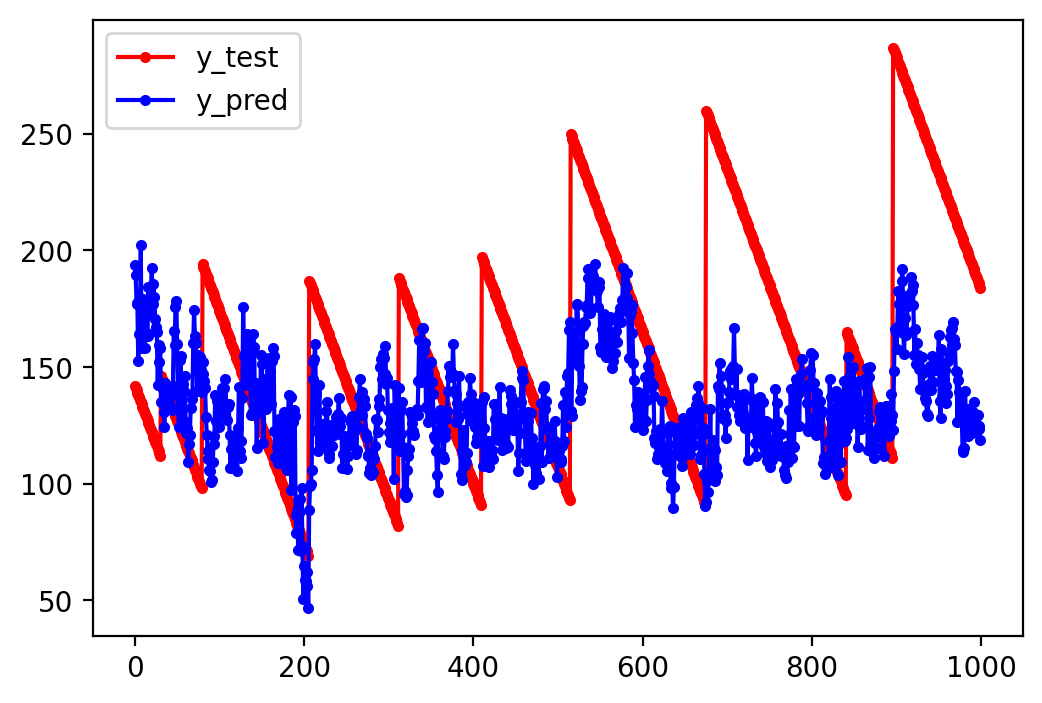

In [68]:
lgbm_r = LGBMRegressor()
lgbm_r.fit(X_train_ext, y_train)
y_pred = lgbm_r.predict(X_test_ext)
show_regression_result(y_test, y_pred,1000)

# LSTM 사용

- LSTM 윈도우를 충분히 크게 잡으면 윈도우 내의 중요한 신호를 파악하여 사용할 수 있다
- 장단기 신호를 전파할 수 있다

- LSTM 신경망은 (samples, time steps, features) 구조의 입력를 필요로 한다

## 시퀀스를 n_steps 크기로 나누는 함수

- (주의) 아래 함수는 마지막 샘플은 포함하지 않는다
- 현재 데이터로 현재를 예측하는 것이 맞는지는 응용에 따라서 점검해야 한다

In [ ]:
def split_seq(sequence, n_steps):
  x = []
  for i in range(len(sequence)- n_steps):
    x.append(sequence[i:i+ n_steps])
  return np.array(x)

In [ ]:
# 예제
# 특성수가 3인 시계열 데이터를 스텝수가 4가 되도록 3차원 어레이로 만드는 함수

x = np.arange(30).reshape(-1,3)
print(x)
inp = split_seq(x,4)
print('LSTM 모델 입력용 데이터:',inp.shape)
inp

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]
 [21 22 23]
 [24 25 26]
 [27 28 29]]
LSTM 모델 입력용 데이터: (6, 4, 3)


array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11]],

       [[ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11],
        [12, 13, 14]],

       [[ 6,  7,  8],
        [ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]],

       [[ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17],
        [18, 19, 20]],

       [[12, 13, 14],
        [15, 16, 17],
        [18, 19, 20],
        [21, 22, 23]],

       [[15, 16, 17],
        [18, 19, 20],
        [21, 22, 23],
        [24, 25, 26]]])

## 입력 시퀀스 만들기

In [ ]:
# 주의: 같은 id인 엔진의 데이터로만 학습데이터 스텝을 만들어야 한다
n_steps = 50
res = []
for id in train_df['id'].unique():
  res.append(split_seq(train_df[train_df['id']==id][features], n_steps))
seq_array = np.concatenate(res)
seq_array.shape

(15631, 50, 24)

In [ ]:
# 각 동일한 엔진에 대한 데이터를 50개씩 사용해야 하므로 샘플수가 줄어들었다
train_df.shape

(20631, 28)

## 회귀 모델

In [ ]:
# 회귀 레이블 얻기
res2 = []
label = ["RUL"]
for id in train_df['id'].unique():
  res2.append(train_df[train_df['id']==id][label][n_steps:len(train_df)])
label_array = np.concatenate(res2)
label_array.shape

(15631, 1)

In [ ]:
seq_array.shape

(15631, 50, 24)

In [ ]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(n_steps, nb_features), # 스텝 수, 특성 수
         units=100))                          # 셀의 수

model.add(Dense(1)) # 1
model.add(Activation("linear"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               50000     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 50101 (195.71 KB)
Trainable params: 50101 (195.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mse'])

history = model.fit(seq_array, label_array, epochs=100, batch_size=50, validation_split=0.1, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='min')])

print(history.history.keys())

Epoch 1/100
282/282 - 14s - loss: 6503.4136 - mse: 6503.4136 - val_loss: 7355.1963 - val_mse: 7355.1963 - 14s/epoch - 48ms/step
Epoch 2/100
282/282 - 7s - loss: 4068.7478 - mse: 4068.7478 - val_loss: 5099.0078 - val_mse: 5099.0078 - 7s/epoch - 24ms/step
Epoch 3/100
282/282 - 7s - loss: 2767.8184 - mse: 2767.8184 - val_loss: 3624.7349 - val_mse: 3624.7346 - 7s/epoch - 25ms/step
Epoch 4/100
282/282 - 7s - loss: 1730.2092 - mse: 1730.2092 - val_loss: 2199.9211 - val_mse: 2199.9209 - 7s/epoch - 26ms/step
Epoch 5/100
282/282 - 7s - loss: 1277.9286 - mse: 1277.9286 - val_loss: 2184.4414 - val_mse: 2184.4414 - 7s/epoch - 27ms/step
Epoch 6/100
282/282 - 8s - loss: 1020.4630 - mse: 1020.4630 - val_loss: 1671.3948 - val_mse: 1671.3950 - 8s/epoch - 29ms/step
Epoch 7/100
282/282 - 9s - loss: 893.2122 - mse: 893.2122 - val_loss: 1208.4989 - val_mse: 1208.4989 - 9s/epoch - 33ms/step
Epoch 8/100
282/282 - 10s - loss: 838.7070 - mse: 838.7070 - val_loss: 1254.0363 - val_mse: 1254.0363 - 10s/epoch - 36

In [ ]:
y_pred = model.predict(seq_array,verbose=1, batch_size=50)

313/313 [==============================] - 3s 8ms/step


MAE= 17.935367407004698
rmse= 28.261741897653835
max error= 155.96170043945312
R2= 0.7553834440136098


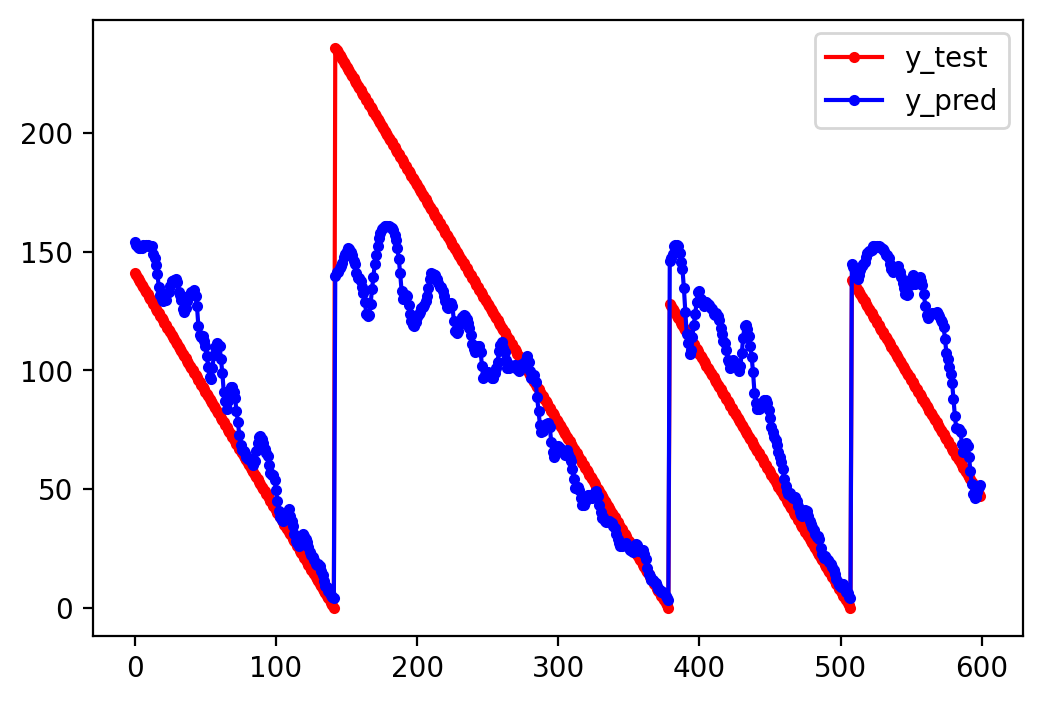

In [ ]:
show_regression_result(label_array.ravel(), y_pred.ravel(),600)

## 테스트 데이터에 적용
- 테스트 데이터의 각 엔진별 마지막 50 샘플을 입력으로 사용한다
- 마지막 샘플수가 50보다 작은 경우는 테스트할 수 없다

In [ ]:
sequence_cols = features
sequence_length = 50
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:]
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 24)

In [ ]:
# test_df의 마지막 샘플의 크기가 50 이상인지를 확인
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

In [ ]:
len(y_mask), np.array(y_mask).sum()

(100, 93)

- 회귀 레이블 얻기

In [ ]:
y_test = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
y_test

array([ 69,  82,  91,  93,  91,  95, 111,  96,  97, 124,  95,  83,  84,
        50,  28,  87,  16,  57, 113,  20, 119,  66,  97,  90, 115,   8,
        48, 106,   7,  11,  19,  21,  50,  28,  18,  10,  59, 109, 114,
        47, 135,  92,  21,  79, 114,  29,  26,  97, 137,  15, 103,  37,
       114, 100,  21,  54,  72,  28, 128,  14,  77,   8, 121,  94, 118,
        50, 131, 126, 113,  10,  34, 107,  63,  90,   8,   9, 137,  58,
        89, 116, 115, 136,  28,  38,  20,  85,  55, 128, 137,  82,  59,
       117,  20], dtype=int64)

In [ ]:
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [ ]:
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(93, 50, 24)
(93, 1)


In [ ]:
y_pred = model.predict(seq_array_test_last)

3/3 [==============================] - 0s 6ms/step


MAE= 13.710741217418384
rmse= 19.14614944504944
max error= 77.04267883300781
R2= 0.7822372571416689


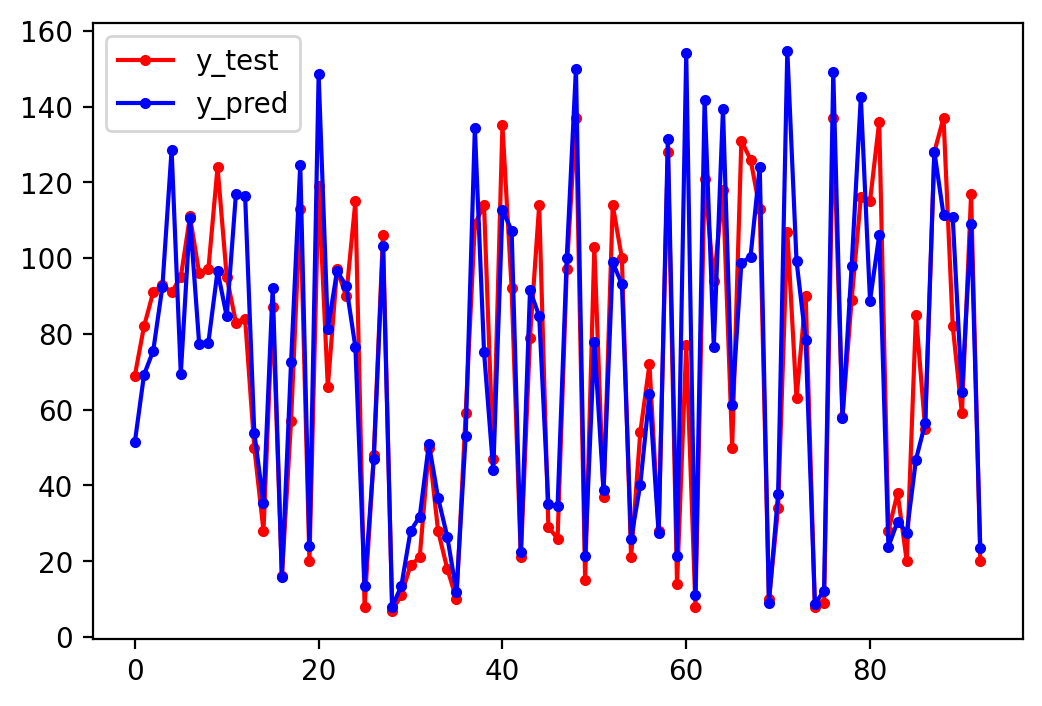

In [ ]:
# 회귀 성능
show_regression_result(y_test, y_pred.ravel(),100)

## 이진 분류 모델

In [ ]:
# 이진분류 레이블 얻기
res2 = []
label = ["label"]
for id in train_df['id'].unique():
  res2.append(train_df[train_df['id']==id][label][n_steps:len(train_df)])
label_array = np.concatenate(res2)
label_array.shape

(15631, 1)

- softmax 대신 sigmoid를 사용할 수 있다 (이진 분류시)
- loss='binary_crossentropy'로 지정해야 한다

In [ ]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(n_steps, nb_features), # 스텝 수, 특성 수
         units=100))                          # 셀의 수

model.add(Dense(units=nb_out, activation='sigmoid'))

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               50000     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 50101 (195.71 KB)
Trainable params: 50101 (195.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
seq_array.shape, label_array.shape

((15631, 50, 24), (15631, 1))

In [ ]:
%%time
# fit the network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.1, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto')])

Epoch 1/100
71/71 [==============================] - 9s 87ms/step - loss: 0.3246 - accuracy: 0.8575 - val_loss: 0.1837 - val_accuracy: 0.9239
Epoch 2/100
71/71 [==============================] - 5s 73ms/step - loss: 0.1401 - accuracy: 0.9473 - val_loss: 0.1665 - val_accuracy: 0.9335
Epoch 3/100
71/71 [==============================] - 5s 70ms/step - loss: 0.1209 - accuracy: 0.9527 - val_loss: 0.1223 - val_accuracy: 0.9418
Epoch 4/100
71/71 [==============================] - 4s 64ms/step - loss: 0.0971 - accuracy: 0.9612 - val_loss: 0.0727 - val_accuracy: 0.9687
Epoch 5/100
71/71 [==============================] - 5s 71ms/step - loss: 0.0955 - accuracy: 0.9606 - val_loss: 0.1208 - val_accuracy: 0.9450
Epoch 6/100
71/71 [==============================] - 5s 68ms/step - loss: 0.0902 - accuracy: 0.9613 - val_loss: 0.0836 - val_accuracy: 0.9584
Epoch 7/100
71/71 [==============================] - 5s 74ms/step - loss: 0.0837 - accuracy: 0.9664 - val_loss: 0.1017 - val_accuracy: 0.9546
CPU ti

In [ ]:
label_array_test_last = test_df.groupby('id')['label'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1)
label_array_test_last.shape

(93, 1)

In [ ]:
# 이진 분류 확률을 얻는다
y_pred_test = model.predict(seq_array_test_last)
show_clf_result(label_array_test_last, y_pred_test > 0.5)

3/3 [==============================] - 1s 7ms/step
[[67  1]
 [ 6 19]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95        68
           1       0.95      0.76      0.84        25

    accuracy                           0.92        93
   macro avg       0.93      0.87      0.90        93
weighted avg       0.93      0.92      0.92        93

